# PySyDy — Simulation Engine (Notebook Version)

This notebook recreates the `Simulation` class and its helpers, block by block, so you can run, test, and tweak the code interactively.  
Each section is a Markdown heading followed by a single Python code cell.


## 0  Environment setup  

Import every external library the engine needs and expose two handy pint helpers:

* `ureg` — the shared pint registry  
* `Q_`  — shorthand for `ureg.Quantity`


In [1]:
# 0. Environment setup
# --------------------
# This cell imports the scientific stack, configures matplotlib for inline plots,
# and loads the project-wide pint registry (`units` is the wrapper shipped with PySyDy).

import sys
import importlib
import pandas as pd

# -- networkx --------------------------------------------------------------
try:
    import networkx as nx
except ImportError:          # keep notebook usable even if networkx is absent
    nx = None
    print("[INFO] networkx not found – loop detection will be skipped.")

# -- matplotlib ------------------------------------------------------------
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 110     # crisper inline images

# -- tqdm (progress bar) ---------------------------------------------------
try:
    from tqdm import trange
except ImportError:
    trange = range                    # silent fallback
    print("[INFO] tqdm not installed – progress bars disabled.")

# -- pint registry via project wrapper -------------------------------------
try:
    from units import units           # <- your UnitManager singleton
except ImportError as e:
    raise RuntimeError(
        "Cannot import the 'units' package. "
        "Ensure the PySyDy repository (or its installed wheel) is on PYTHONPATH."
    ) from e

ureg = units.ureg
Q_   = ureg.Quantity

# quick confirmation
print("Environment ready:")
print(f"  pandas      : {pd.__version__}")
print(f"  networkx    : {nx.__version__ if nx else 'not available'}")
print(f"  pint        : {ureg}")


Environment ready:
  pandas      : 1.5.3
  networkx    : 3.4.2
  pint        : <pint.registry.UnitRegistry object at 0x0000021392D5D050>


## 1  Global constants and pint helpers  

We already exposed `ureg` and `Q_` in the previous cell.  
Here we declare a few cross-module constants that the simulation engine relies on:

| Constant | Purpose |
|----------|---------|
| `DEFAULT_EPSILON` | Finite-difference step used when we perturb an input variable to estimate link polarity. |
| `NUMERIC_THRESHOLD` | Smallest absolute change in an output that we still treat as meaningful (anything smaller is considered zero). |
| `TIME_UNIT_ALIASES` | Convenience mapping so model scripts can accept everyday time words (“hour”, “day”, “year”) and still pass canonical pint symbols to the registry. |


In [2]:
# 1. Global constants and pint helpers
# ------------------------------------

# step size for numeric perturbation when estimating link polarity
DEFAULT_EPSILON = 1e-6

# if |Δoutput| falls below this value we treat the response as zero
NUMERIC_THRESHOLD = 1e-12

# Acceptable human-friendly time strings → canonical pint symbols
TIME_UNIT_ALIASES = {
    "sec"     : "s",
    "second"  : "s",
    "seconds" : "s",
    "min"     : "minute",
    "minute"  : "minute",
    "minutes" : "minute",
    "hr"      : "hour",
    "hour"    : "hour",
    "hours"   : "hour",
    "day"     : "day",
    "days"    : "day",
    "yr"      : "year",
    "year"    : "year",
    "years"   : "year",
}

# Make sure dimensionless really exists (pint sometimes uses 'dimensionless' or '')
ureg.define("dimensionless = []")

print(f"DEFAULT_EPSILON   : {DEFAULT_EPSILON}")
print(f"NUMERIC_THRESHOLD : {NUMERIC_THRESHOLD}")


DEFAULT_EPSILON   : 1e-06
NUMERIC_THRESHOLD : 1e-12


## 2  Simulation class — constructor  

This first code block defines the `Simulation` shell and implements `__init__`.  
Later sections will fill in the remaining methods (`step`, `run`, plotting, etc.).  
Key tasks performed in the constructor:

1. Normalise the user-supplied timestep and convert it to a pint `Quantity`.  
2. Convert the incoming lists of component objects into fast name→object dictionaries.  
3. Build a topological order for auxiliaries so they can be recomputed safely.  
4. Run `validate_model()` (unit checks + quick influence evaluation).  
5. Capture the initial state and, if `networkx` is available, attempt automatic loop detection.  


In [3]:
# 2. Simulation class — constructor
# ---------------------------------

class Simulation:
    """
    Core engine that owns all model components, advances time, and (optionally)
    analyses the feedback-loop structure.
    """

    # --------------------------------------------------- #
    # constructor
    # --------------------------------------------------- #
    def __init__(
        self,
        stocks,
        flows,
        auxiliaries,
        parameters,
        timestep: float | int = 1.0,
        timestep_unit: str   = "day",
    ):
        # 1) time handling ------------------------------------------------
        timestep_unit = TIME_UNIT_ALIASES.get(timestep_unit.lower(), timestep_unit)
        self.timestep = units.get_quantity(timestep, timestep_unit)
        self.time     = Q_(0, timestep_unit)

        # 2) component dictionaries --------------------------------------
        self.stocks       = {s.name: s for s in stocks}
        self.flows        = {f.name: f for f in flows}
        self.auxiliaries  = {a.name: a for a in auxiliaries}
        self.parameters   = {p.name: p for p in parameters}

        # 3) misc bookkeeping -------------------------------------------
        self.history           = []
        self.loops             = []        # filled after loop detection
        self._link_polarities  = {}
        self.epsilon           = DEFAULT_EPSILON
        self.numeric_threshold = NUMERIC_THRESHOLD

        # 4) pre-compute auxiliary order --------------------------------
        self._sorted_aux_names = self._get_auxiliary_calculation_order()

        # 5) basic validation (units + callable sanity checks) ----------
        self.validate_model()

        # 6) capture initial state for polarity detection ---------------
        try:
            self._capture_initial_state()
            if nx is not None:
                self._find_loops_and_polarity(self._initial_state_objects)
            else:
                print("[INFO] networkx not installed – loop detection skipped.")
        except Exception as e:
            print(f"[WARN] Automatic loop detection skipped ({e})")

    # ================================================================== #
    # place-holders filled in later notebook cells
    # ================================================================== #
    def _get_auxiliary_calculation_order(self):
        # implementation appears in Section 6
        raise NotImplementedError

    def validate_model(self):
        # implemented in Section 5
        raise NotImplementedError

    def _capture_initial_state(self):
        """
        Compute initial values for all auxiliaries and flows,
        store them in `self._initial_state_objects` for polarity analysis.
        """
        state = self._get_system_state(get_objects=True)

        # auxiliaries first (topological order)
        for name in self._sorted_aux_names:
            self.auxiliaries[name].calculate_value(state)

        # flows next
        for fl in self.flows.values():
            fl.calculate_rate(state)

        self._initial_state_objects = state  # keep full object view

    # `_get_system_state`, `_find_loops_and_polarity`, `step`, `run`, etc.
    # will be added in the following sections.


### 2.1  Private helper `_get_system_state`

A single utility that hands back the model’s *current* state in one of two flavours:

* **objects view** (`get_objects=True`) – each entry is the **live** component object  
  (stocks, flows, auxiliaries, parameters).  Calculation functions use this form so
  they can read `.value` or `.rate` and even update them in-place.

* **values snapshot** (`get_objects=False`, the default) – each entry is the
  component’s stored pint `Quantity`.  We use this read-only form when writing
  to `self.history` because it’s safe to serialise.

The helper always includes the current simulation time (`self.time`) so rate
functions can refer to it if they wish.


In [4]:
# 2.1  _get_system_state helper
# -----------------------------
def _get_system_state(self, *, get_objects: bool = False):
    """
    Return the current model state as a dict.

    Parameters
    ----------
    get_objects : bool, default False
        If True, each entry is the live component *object*.
        If False, each entry is the component's current pint Quantity
        (safe for storing in history).

    Returns
    -------
    dict with keys 'stocks', 'flows', 'auxiliaries', 'parameters', 'time'
    """
    if get_objects:
        return {
            "stocks"      : self.stocks,
            "flows"       : self.flows,
            "auxiliaries" : self.auxiliaries,
            "parameters"  : self.parameters,
            "time"        : self.time,
        }

    # snapshot of values only
    return {
        "stocks"      : {n: s.value for n, s in self.stocks.items()},
        "flows"       : {n: f.rate  for n, f in self.flows.items()},
        "auxiliaries" : {n: a.value for n, a in self.auxiliaries.items()},
        "parameters"  : {n: p.value for n, p in self.parameters.items()},
        "time"        : self.time,
    }

# patch the method onto the existing Simulation class
Simulation._get_system_state = _get_system_state

print("Simulation._get_system_state attached.")


Simulation._get_system_state attached.


### 2.2  Private helper `_record_state`

After every timestep we capture a read-only snapshot of the model so the
results can be converted to a DataFrame later.  
The snapshot is the **values** form of `_get_system_state` and is appended to
`self.history` (a plain Python list).


In [5]:
# 2.2  _record_state helper
# -------------------------
def _record_state(self):
    """Append the current values snapshot to `self.history`."""
    self.history.append(self._get_system_state(get_objects=False))

# attach the method to the class
Simulation._record_state = _record_state

print("Simulation._record_state attached.")


Simulation._record_state attached.


## 3  Simulation class — time-stepping API  

Two core methods turn a static model into a running simulation.

* **`step()`**  
  1. Recalculate every auxiliary (in topological order)  
  2. Recalculate every flow rate  
  3. Update each stock with its net inflow – outflow over the current timestep  
  4. Store a snapshot via `_record_state()`  
  5. Advance the model clock (`self.time += self.timestep`)

* **`run(duration)`**  
  * Accepts either a raw number (interpreted in `timestep_unit`) or a pint `Quantity`.  
  * Confirms that `duration` and `self.timestep` share the same dimensionality.  
  * Executes `step()` in a loop, wrapped by a `tqdm` progress-bar when available.


In [6]:
# 3. step() and run()
# -------------------

def step(self):
    """
    Advance the system by one timestep:
    auxiliaries ➜ flows ➜ stocks ➜ record ➜ clock += dt
    """
    # live object view so lambdas can reference other components
    state = self._get_system_state(get_objects=True)

    # 1. auxiliaries (deterministic order)
    for name in self._sorted_aux_names:
        self.auxiliaries[name].calculate_value(state)

    # 2. flow rates
    for fl in self.flows.values():
        fl.calculate_rate(state)

    # 3. update stocks
    for st in self.stocks.values():
        st.update(self.timestep)

    # 4. save snapshot
    self._record_state()

    # 5. advance time
    self.time += self.timestep


def run(self, duration):
    """
    Run the model for *duration*.

    Parameters
    ----------
    duration : int | float | pint.Quantity
        If numeric, it is interpreted in the same unit as `self.timestep`.
    """
    # normalise duration to a pint.Quantity
    if not hasattr(duration, "units"):
        # allow aliases such as "day" / "days"
        default_unit = str(self.timestep.units)
        duration_q   = units.get_quantity(duration, default_unit)
    else:
        duration_q = duration

    # sanity-check dimensionality (e.g. can't run "12 dollars")
    if duration_q.dimensionality != self.timestep.dimensionality:
        raise ValueError(
            f"Duration unit {duration_q.units} incompatible with timestep unit {self.timestep.units}"
        )

    # number of iterations as an int
    n_steps = int((duration_q / self.timestep).to_base_units().magnitude)

    for _ in trange(n_steps, desc="Simulating"):
        self.step()


# attach both methods
Simulation.step = step
Simulation.run  = run

print("Simulation.step and Simulation.run attached.")


Simulation.step and Simulation.run attached.


## 4  Result utilities  

These helpers turn the raw `self.history` list into user-friendly outputs:

| Method | Returns | Notes |
|--------|---------|-------|
| `get_results()` | `pandas.DataFrame` whose index is **time (Quantity)** and whose columns contain pint Quantities for every stock, flow and auxiliary. | Keeps units intact for downstream calculations. |
| `get_results_for_plot()` | Same DataFrame but with index → plain numbers and every Quantity → `.magnitude`. | Perfect for plotting or CSV export. |
| `plot_each_stock()` | One simple line chart per stock, automatically labelled with its unit and the model’s time unit. | Uses matplotlib inline; no additional imports required. |


In [7]:
# 4. Result utilities
# -------------------

def get_results(self):
    """
    Return a tidy DataFrame (index = time Quantity) that merges every
    snapshot stored in `self.history`.  Columns are added lazily: if
    a variable appears for the first time at t>0 the column is created
    and back-filled with NaN.
    """
    if not self.history:
        raise RuntimeError("No history available. Call run() first.")

    df = pd.DataFrame(self.history)
    out = df[["time"]].copy()

    for category in ("stocks", "flows", "auxiliaries"):
        for i, rec in enumerate(df[category]):
            for name, val in rec.items():
                if name not in out.columns:
                    out[name] = pd.NA
                out.loc[i, name] = val

    return out.set_index("time")


def get_results_for_plot(self):
    """
    Same as get_results() but converts every Quantity to its .magnitude
    and turns the time index into plain floats—ready for matplotlib.
    """
    df = self.get_results().copy()

    # index → numeric
    if hasattr(df.index[0], "magnitude"):
        df.index = df.index.map(lambda q: q.magnitude)

    # columns → numeric
    for col in df.columns:
        sample = df[col].iloc[0]
        if hasattr(sample, "magnitude"):
            df[col] = df[col].apply(lambda q: q.magnitude)

    return df


def plot_each_stock(self):
    """
    Convenience plot: every stock gets its own line chart.
    """
    numeric = self.get_results_for_plot()
    time_unit = str(self.timestep.units)

    for s in self.stocks.values():
        if s.name not in numeric.columns:
            continue
        plt.figure(figsize=(7, 4))
        plt.plot(numeric.index, numeric[s.name])
        plt.title(s.name)
        plt.xlabel(f"Time [{time_unit}]")
        plt.ylabel(f"{s.name} [{s.unit}]")
        plt.grid(True)
        plt.show()


# attach to class
Simulation.get_results          = get_results
Simulation.get_results_for_plot = get_results_for_plot
Simulation.plot_each_stock      = plot_each_stock

print("Result utilities attached.")


Result utilities attached.


## 5  Unit-validation suite  

Before a run starts we want to be sure two things are true:

* **Structural consistency** Every component has a declared unit and every
  flow’s unit equals its source-stock (or target-stock) unit divided by the
  simulation timestep unit.

* **Callable sanity** Every auxiliary and flow rate function can be evaluated
  once without throwing an exception.

The three helpers below enforce those rules.

| Method | What it does |
|--------|--------------|
| `check_units()` | Collects all unit omissions and incompatibilities, prints them, then raises `ValueError` if anything is wrong. |
| `validate_influences()` | Runs one full recalculation pass (aux → flows) on the current state; if any lambda crashes you’ll see the traceback immediately. |
| `validate_model()` | Convenience wrapper that prints *“Running checks… / Passed.”* or aborts on first failure. |


In [8]:
# 5. Unit-validation helpers
# --------------------------

def check_units(self):
    """Raise ValueError if any component has missing or mismatched units."""
    problems = []

    # stocks and parameters must always declare a unit
    for st in self.stocks.values():
        if st.unit is None:
            problems.append(f"Stock '{st.name}' missing unit")

    for par in self.parameters.values():
        if par.unit is None:
            problems.append(f"Parameter '{par.name}' missing unit")

    # auxiliaries likewise
    for aux in self.auxiliaries.values():
        if aux.unit is None:
            problems.append(f"Auxiliary '{aux.name}' missing unit")

    # flows must match stock / timestep
    for fl in self.flows.values():
        if fl.unit is None:
            problems.append(f"Flow '{fl.name}' missing unit")
            continue

        ref_stock = fl.source_stock or fl.target_stock
        if ref_stock and ref_stock.unit:
            expected = ref_stock.unit / self.timestep.units
            if fl.unit.dimensionality != expected.dimensionality:
                problems.append(
                    f"Flow '{fl.name}' unit {fl.unit} incompatible with "
                    f"{ref_stock.name}/timestep ({expected})"
                )

    if problems:
        for msg in problems:
            print(" •", msg)
        raise ValueError("[UNIT CHECK FAILED]")
    # else silent success


def validate_influences(self):
    """
    Recalculate auxiliaries and flows once to ensure user-supplied
    functions execute without errors.
    """
    state = self._get_system_state(get_objects=True)

    # auxiliaries
    for name in self._sorted_aux_names:
        self.auxiliaries[name].calculate_value(state)

    # flows
    for fl in self.flows.values():
        fl.calculate_rate(state)


def validate_model(self):
    """Wrapper that prints a friendly summary of the two checks above."""
    print("[UNIT CHECK] Running checks…")
    self.check_units()
    self.validate_influences()
    print("[UNIT CHECK] Passed.")


# attach to class
Simulation.check_units        = check_units
Simulation.validate_influences = validate_influences
Simulation.validate_model     = validate_model

print("Validation helpers attached.")


Validation helpers attached.


## 6  Loop detection and dependency graph  

PySyDy can build a causal graph of every dynamic component and, when
`networkx` is installed, automatically detect feedback loops and
classify them as **reinforcing** (+) or **balancing** (–).

The logic is split into three helpers:

1. **`_get_auxiliary_calculation_order()`**  
   *Topologically* sorts auxiliaries so each one’s inputs are
   evaluated before the auxiliary itself.

2. **`_build_dependency_graph()`**  
   Creates a directed graph whose nodes are *all* dynamic components
   (stocks, flows, auxiliaries) plus parameters that feed something.
   Edges carry a preliminary “sign”:  
   * Flow → Target-Stock = +1  
   * Flow → Source-Stock = –1  
   * Anything else = placeholder ‘calculate’

3. **`_find_loops_and_polarity()`**  
   a. Starts from the dependency graph.  
   b. Runs `_estimate_link_sign()` on every ambiguous edge to get a
      numeric +1 / –1 / 0.  
   c. Extracts every directed cycle and multiplies the signs to decide
      whether the loop is Reinforcing (R) or Balancing (B).  
   d. Stores a pretty list in `self.loops` and returns the graph
      (useful for later plotting).


In [9]:
# 6. Dependency graph + loop detection
# ------------------------------------

def _get_auxiliary_calculation_order(self):
    """
    Return a list of auxiliary names in an order that respects
    their declared `.inputs` dependencies.
    """
    if not self.auxiliaries:
        return []

    if nx is None:
        # no networkx: fall back to insertion order
        return list(self.auxiliaries.keys())

    g = nx.DiGraph()
    g.add_nodes_from(self.auxiliaries.keys())

    for name, aux in self.auxiliaries.items():
        for inp in getattr(aux, "inputs", []):
            if inp in self.auxiliaries:   # only aux→aux edges
                g.add_edge(inp, name)

    try:
        return list(nx.topological_sort(g))
    except nx.NetworkXUnfeasible as e:
        cycles = [" → ".join(c + [c[0]]) for c in nx.simple_cycles(g)]
        raise ValueError(f"Cyclic dependency among auxiliaries: {cycles}") from e


def _build_dependency_graph(self):
    """
    Return a NetworkX DiGraph with every dynamic component as a node
    and preliminary signed edges.
    """
    g = nx.DiGraph()

    # add nodes
    for name in (*self.stocks, *self.flows, *self.auxiliaries, *self.parameters):
        g.add_node(name)

    # add edges: Aux/Flow inputs
    for comp in (*self.flows.values(), *self.auxiliaries.values()):
        for inp in getattr(comp, "inputs", []):
            g.add_edge(inp, comp.name, sign="calculate")

    # flow ↔ stock
    for f in self.flows.values():
        if f.target_stock:
            g.add_edge(f.name, f.target_stock.name, sign=+1)
        if f.source_stock:
            g.add_edge(f.name, f.source_stock.name, sign=-1)

    return g


def _find_loops_and_polarity(self, base_state):
    """
    Detect every feedback loop and classify its polarity.

    `base_state` is the object view captured at t=0 so we can
    perturb variables without touching the live model.
    """
    if nx is None:
        self.loops = [("?", "Loop detection skipped (networkx missing)")]
        return None

    G = self._build_dependency_graph()

    # resolve unknown signs via finite-difference
    for u, v, data in G.edges(data=True):
        if data["sign"] == "calculate":
            data["sign"] = self._estimate_link_sign(u, v, base_state)

    # store for pretty printers
    self._link_polarities = {(u, v): d["sign"] for u, v, d in G.edges(data=True)}

    # detect cycles
    self.loops = []
    for cyc in nx.simple_cycles(G):
        # multiply edge signs
        polarity = 1
        for i in range(len(cyc)):
            u, v = cyc[i], cyc[(i + 1) % len(cyc)]
            polarity *= G.edges[u, v]["sign"]
        label = "R (+)" if polarity > 0 else "B (-)" if polarity < 0 else "N (0)"
        self.loops.append((label, " → ".join(cyc + [cyc[0]])))

    return G


# attach to class
Simulation._get_auxiliary_calculation_order = _get_auxiliary_calculation_order
Simulation._build_dependency_graph         = _build_dependency_graph
Simulation._find_loops_and_polarity        = _find_loops_and_polarity

print("Dependency graph and loop-detection methods attached.")


Dependency graph and loop-detection methods attached.


### 6.1  Numeric polarity helpers  

These utilities let the engine assign a concrete + / – / 0 sign to any
edge whose polarity cannot be inferred purely from model structure.

1. **`_update_auxiliaries_and_flows(state)`**  
   Re-evaluates every auxiliary and flow _inside an arbitrary copy of the
   system state_.  Used when we perturb one variable and need all
   downstream values refreshed.

2. **`_estimate_link_sign(inp, out, base_state)`**  
   *Finite-difference test*  
   *  Copy the base state twice (plus/minus).  
   *  Bump `inp` by `±epsilon`.  
   *  Recalculate downstream aux+flows in each copy.  
   *  Compare `out` in the two copies:  
      | Δ output | < threshold → 0  
      positive  → +1  
      negative  → –1  
   *  Special case: direct **Flow → Stock** edges use definitional
     polarity (+ for target, – for source) with no numeric work.

3. **`_calculate_link_polarities(G, base_state)`**  
   Loops over every edge whose current sign is the placeholder
   “calculate”, calls `_estimate_link_sign`, stores the result in
   `self._link_polarities`, and writes it back onto the graph.


In [10]:
# 6.1  Numeric polarity helpers
# -----------------------------

# ---------- helper to refresh a copied state ----------
def _update_auxiliaries_and_flows(self, state):
    """Recalculate auxiliaries (topo-order) then flows inside *state*."""
    for name in self._sorted_aux_names:
        if name in state["auxiliaries"]:
            state["auxiliaries"][name].calculate_value(state)

    for fl in state["flows"].values():
        fl.calculate_rate(state)


# ---------- helper to fetch / set a component value ----------
def _get_value(self, state, name):
    if name in state["stocks"]:
        return state["stocks"][name].value
    if name in state["auxiliaries"]:
        return state["auxiliaries"][name].value
    if name in state["parameters"]:
        return state["parameters"][name].value
    if name in state["flows"]:
        return state["flows"][name].rate
    return None


def _set_value(self, state, name, value):
    if name in state["stocks"]:
        state["stocks"][name].value = value
    elif name in state["auxiliaries"]:
        state["auxiliaries"][name].value = value
    elif name in state["parameters"]:
        state["parameters"][name].value = value
    elif name in state["flows"]:
        state["flows"][name].rate = value


# ---------- finite-difference sign estimator ----------
def _estimate_link_sign(self, inp, out, base_state):
    """
    Return +1, –1 or 0 for the influence inp ➜ out, based on a small
    perturbation around `base_state`.
    """

    # direct Flow ➜ Stock rules (faster than numeric)
    if inp in self.flows and out in self.stocks:
        fl = self.flows[inp]
        if fl.target_stock and fl.target_stock.name == out:
            return +1
        if fl.source_stock and fl.source_stock.name == out:
            return -1

    # numeric perturbation
    orig_val = self._get_value(base_state, inp)
    if orig_val is None:
        return 0

    # ensure Quantity
    if not isinstance(orig_val, Q_):
        orig_val = Q_(orig_val, ureg.dimensionless)

    delta = Q_(self.epsilon, orig_val.units)

    # plus copy
    plus_state = copy.deepcopy(base_state)
    _set_value(self, plus_state, inp, orig_val + delta)
    _update_auxiliaries_and_flows(self, plus_state)
    plus_out = self._get_value(plus_state, out)

    # minus copy
    minus_state = copy.deepcopy(base_state)
    _set_value(self, minus_state, inp, orig_val - delta)
    _update_auxiliaries_and_flows(self, minus_state)
    minus_out = self._get_value(minus_state, out)

    if plus_out is None or minus_out is None:
        return 0

    # scalar diff
    if isinstance(plus_out, Q_):
        diff = (plus_out - minus_out).to_base_units().magnitude
    else:
        diff = plus_out - minus_out

    if abs(diff) < self.numeric_threshold:
        return 0
    return +1 if diff > 0 else -1


# ---------- iterate all edges that still need a sign ----------
def _calculate_link_polarities(self, G, base_state):
    for u, v, data in G.edges(data=True):
        if data["sign"] == "calculate":
            data["sign"] = _estimate_link_sign(self, u, v, base_state)
    self._link_polarities = {(u, v): d["sign"] for u, v, d in G.edges(data=True)}
    return G


# attach helpers to the class
Simulation._update_auxiliaries_and_flows = _update_auxiliaries_and_flows
Simulation._estimate_link_sign           = _estimate_link_sign
Simulation._calculate_link_polarities    = _calculate_link_polarities

print("Numeric polarity helpers attached.")


Numeric polarity helpers attached.


## 7  Printing helpers  

Two convenience methods for human-readable output:

* **`print_loops()`** – groups detected feedback loops by polarity and numbers them.  
* **`print_relationships()`** – lists every causal link in the model with its calculated sign.


In [11]:
# 7. Printing helpers
# -------------------

def print_loops(self):
    """Pretty-print all detected feedback loops, grouped by polarity."""
    if not self.loops:
        print("No feedback loops detected.")
        return

    groups = {"R (+)": [], "B (-)": [], "N (0)": [], "?": []}
    for lbl, seq in self.loops:
        groups.get(lbl, groups["?"]).append(seq)

    print("\n--- Feedback loops (@ t = 0) ---")
    for heading in ("R (+)", "B (-)", "N (0)", "?"):
        loops = groups[heading]
        if not loops:
            continue
        name = {"R (+)": "Reinforcing",
                "B (-)": "Balancing",
                "N (0)": "Neutral",
                "?":      "Ambiguous"}[heading]
        print(f"\n{name}:")
        for i, seq in enumerate(sorted(loops), 1):
            print(f"  {i}. {seq}")
    print("------------------------------\n")


def print_relationships(self):
    """List every model edge with its sign (+,–,0,?)."""
    if not self._link_polarities:
        print("Link polarities not yet calculated.")
        return

    print("\n--- All causal links (@ t = 0) ---")
    for (u, v), sgn in sorted(self._link_polarities.items()):
        symbol = {+1: "+", -1: "–", 0: "0"}.get(sgn, "?")
        par_tag = "(P)" if u in self.parameters else ""
        print(f"  {u}{par_tag}  ->  {v}   : {symbol}")
    print("----------------------------------\n")


# attach to class
Simulation.print_loops         = print_loops
Simulation.print_relationships = print_relationships

print("Printing helpers attached.")


Printing helpers attached.


## 8  Graph and result-plotting helpers  

Visuals are often the quickest sanity-check.  
We add two convenience functions:

| Helper | What it draws | Key options |
|--------|---------------|-------------|
| `plot_structure_graph()` | A coloured NetworkX diagram of every node (Stock = blue, Flow = red, Auxiliary = green, Parameter = grey) with each edge labelled **+ / – / 0 / ?**. | Layout: “spring” (default) or “kamada\_kawai”; PNG filename, DPI, figure size. |
| `plot_results()` | Time-series line plots for any subset of variables.  Can save one combined PNG or one PNG per variable. | `columns`, `together=True/False`, `filename`, figure/style kwargs. |


In [12]:
# 8. Visual helpers
# -----------------

def plot_structure_graph(
    self,
    filename="structure_graph.png",
    layout="spring",
    figsize=(14, 10),
    dpi=300,
    **kwargs,
):
    """Draw the causal graph with edge polarities and save to PNG."""

    if nx is None:
        print("Cannot plot structure graph: networkx not installed.")
        return
    if not self._link_polarities:
        print("Cannot plot: link polarities dict is empty.")
        return

    G = nx.DiGraph()
    G.add_nodes_from(self._link_polarities.keys())

    # nodes (coloured by type)
    node_colors = {}
    for name in set([n for edge in self._link_polarities for n in edge]):
        if name in self.stocks:
            node_colors[name] = "skyblue"
        elif name in self.flows:
            node_colors[name] = "lightcoral"
        elif name in self.auxiliaries:
            node_colors[name] = "lightgreen"
        else:
            node_colors[name] = "lightgrey"  # parameters

        G.add_node(name)

    # edges with sign labels
    edge_labels = {}
    for (u, v), s in self._link_polarities.items():
        G.add_edge(u, v)
        edge_labels[(u, v)] = {+1: "+", -1: "–", 0: "0"}.get(s, "?")

    # choose layout
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    else:  # spring default
        pos = nx.spring_layout(G, k=kwargs.get("k", 0.9), seed=kwargs.get("seed", 42))

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_color=list(node_colors.values()), node_size=800)
    nx.draw_networkx_edges(G, pos, arrowstyle="-|>", arrowsize=15, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=8)
    plt.axis("off")
    plt.title("Model structure with link polarities (@ t = 0)")
    plt.tight_layout()
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close()
    print(f"Structure graph saved ➜ {filename}")


def plot_results(
    self,
    columns=None,
    together=True,
    filename="results.png",
    figsize=(12, 6),
    dpi=300,
    **kwargs,
):
    """
    Plot simulation results.

    Parameters
    ----------
    columns   : list[str] | None
        Which variables to plot.  None = all stocks, flows, auxiliaries.
    together  : bool
        True  => one combined figure;  
        False => one PNG per variable (filename_varname.png).
    filename  : str
        Base filename for PNG(s).
    """
    df = self.get_results_for_plot()
    if df.empty:
        print("No results to plot – run the simulation first.")
        return

    if columns is None:
        columns = [*self.stocks.keys(), *self.flows.keys(), *self.auxiliaries.keys()]
        columns = [c for c in columns if c in df.columns]

    if together:
        plt.figure(figsize=figsize)
        df[columns].plot(ax=plt.gca())
        plt.title("Simulation results")
        plt.xlabel(f"Time [{self.timestep.units}]")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(filename, dpi=dpi, bbox_inches="tight")
        plt.close()
        print(f"Combined plot saved ➜ {filename}")
    else:
        base, ext = os.path.splitext(filename)
        for col in columns:
            plt.figure(figsize=figsize)
            df[[col]].plot(ax=plt.gca(), legend=False)
            plt.title(col)
            plt.xlabel(f"Time [{self.timestep.units}]")
            plt.grid(True)
            plt.tight_layout()
            f_out = f"{base}_{col.replace(' ', '_')}{ext}"
            plt.savefig(f_out, dpi=dpi, bbox_inches="tight")
            plt.close()
            print(f"Saved ➜ {f_out}")


# attach
Simulation.plot_structure_graph = plot_structure_graph
Simulation.plot_results         = plot_results

print("Graph and result-plot helpers attached.")


Graph and result-plot helpers attached.


## 9  Public getters  

Tiny utility methods so external scripts (or other notebook cells) can
retrieve loop and polarity data without touching private attributes.


In [13]:
# 9. Public getters
# -----------------

def get_loops(self):
    """Return the list of detected feedback loops."""
    return getattr(self, "loops", [])

def get_link_polarities(self):
    """Return a dict {(source, target): sign} for every causal link."""
    return getattr(self, "_link_polarities", {})

# attach
Simulation.get_loops           = get_loops
Simulation.get_link_polarities = get_link_polarities

print("Public getters attached.")


Public getters attached.


## 10  Quick smoke-test  

| Example | Purpose | Expected loops |
|---------|---------|----------------|
| **Lions & cubs** | One stock, one reinforcing birth flow. Verifies unit handling with a simple “count / day” flow. | 1 × Reinforcing |
| **Mini SIR** | Susceptible–Infected–Recovered with infection + recovery flows. Shows both reinforcing and balancing feedback. | 1 × Reinforcing, 1 × Balancing |

Each mini-model will

1. declare units for every component,  
2. build a `Simulation` (unit check must pass),  
3. run 30 days,  
4. print detected loops,  
5. plot each stock.



=== Lions & cubs ===
[UNIT CHECK] Running checks…
[UNIT CHECK] Passed.
[WARN] Automatic loop detection skipped ('Simulation' object has no attribute '_get_value')


Simulating: 100%|██████████| 30/30 [00:00<00:00, 6563.17it/s]

No feedback loops detected.


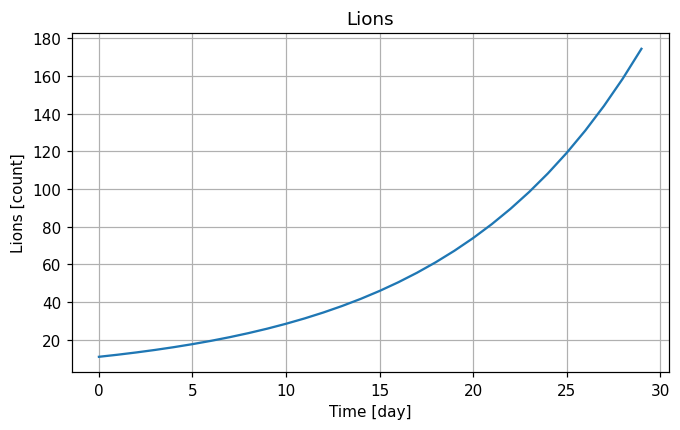


=== Mini SIR ===
[UNIT CHECK] Running checks…
[UNIT CHECK] Passed.
[WARN] Automatic loop detection skipped ('Simulation' object has no attribute '_get_value')


Simulating: 100%|██████████| 30/30 [00:00<00:00, 958.08it/s]

No feedback loops detected.


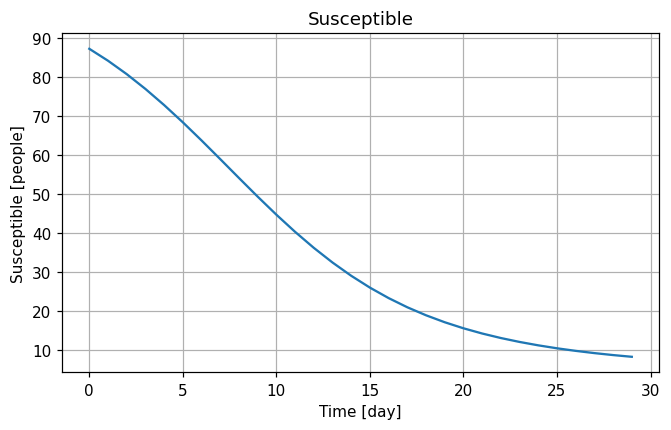

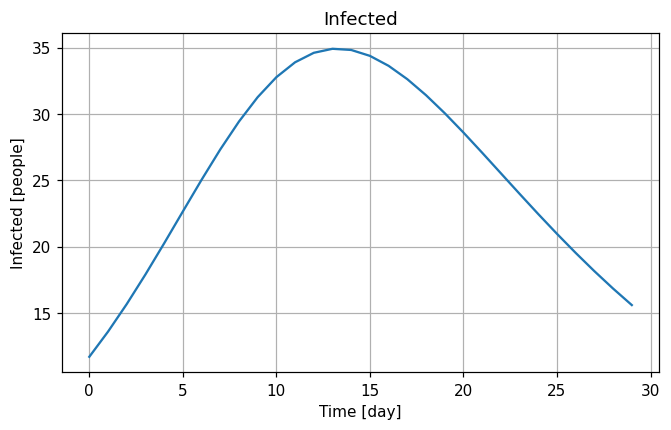

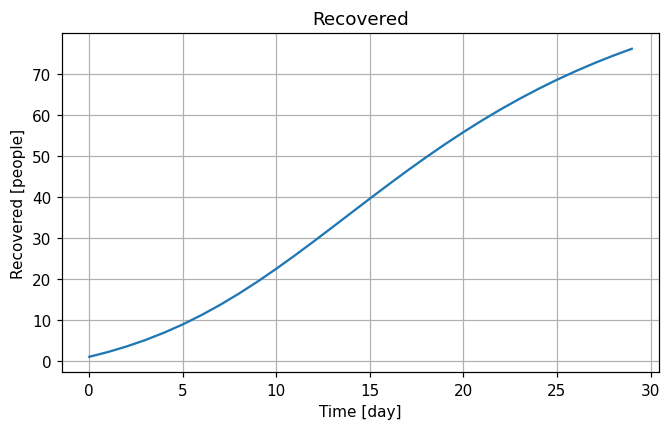

In [ ]:
# 10. Smoke-test models
# ---------------------

# 0) make sure a neutral unit called “count” exists
if "count" not in ureg:          # avoid re-defining on re-run
    ureg.define("count = []")    # dimensionless head-count

# 1) flexible imports
try:
    from pysydy.stock import Stock
    from pysydy.flow import Flow
    from pysydy.parameter import Parameter
except ModuleNotFoundError:
    from stock import Stock
    from flow import Flow
    from parameter import Parameter


# --------------------------------------------------
# 10.1  Lions & cubs  (single reinforcing loop)
# --------------------------------------------------
print("\n=== Lions & cubs ===")

lions = Stock("Lions", 10, unit="count")
birth_rate = Parameter("Birth-rate", 0.10, unit="1 / day")

births = Flow(
    "Births",
    source_stock=None,
    target_stock=lions,
    rate_function=lambda st: (
        st["parameters"]["Birth-rate"].value *
        st["stocks"]["Lions"].value
    ),
    unit="count / day",
    inputs=["Lions", "Birth-rate"],
)

sim_lions = Simulation(
    stocks=[lions],
    flows=[births],
    auxiliaries=[],
    parameters=[birth_rate],
    timestep=1,
    timestep_unit="day",
)
sim_lions.run(30)
sim_lions.print_loops()
sim_lions.plot_each_stock()


# --------------------------------------------------
# 10.2  Mini SIR model  (reinforcing + balancing)
# --------------------------------------------------
print("\n=== Mini SIR ===")

S = Stock("Susceptible", 90, unit="people")
I = Stock("Infected",    10, unit="people")
R = Stock("Recovered",    0, unit="people")

beta  = Parameter("Beta",  0.30, unit="1 / day")
gamma = Parameter("Gamma", 0.10, unit="1 / day")



infection = Flow(
    "Infection",
    source_stock=S,
    target_stock=I,
    rate_function=lambda st: (
        st["parameters"]["Beta"].value *
        st["stocks"]["Susceptible"].value *
        st["stocks"]["Infected"].value /
        (st["stocks"]["Susceptible"].value +
         st["stocks"]["Infected"].value +
         st["stocks"]["Recovered"].value)
    ),
    unit="people / day",
    inputs=["Beta", "Susceptible", "Infected", "Recovered"],
)

recovery = Flow(
    "Recovery",
    source_stock=I,
    target_stock=R,
    rate_function=lambda st: (
        st["parameters"]["Gamma"].value *
        st["stocks"]["Infected"].value
    ),
    unit="people / day",
    inputs=["Gamma", "Infected"],
)

sim_sir = Simulation(
    stocks=[S, I, R],
    flows=[infection, recovery],
    auxiliaries=[],
    parameters=[beta, gamma],
    timestep=1,
    timestep_unit="day",
)
sim_sir.run(30)
sim_sir.print_loops()
sim_sir.plot_each_stock()


## 11  Appendix – Troubleshooting notes  

Below are the issues that trip people up most often and quick ways to
spot (and fix) them while working in this notebook.

| Symptom | Likely Cause | Diagnosis steps | Fix |
|---------|-------------|-----------------|-----|
| **`ModuleNotFoundError: No module named 'networkx'`** when you construct a model | `networkx` is not installed | Run `import networkx as nx` in a scratch cell. If it errors, you don’t have it. | `pip install networkx`  or, if you don’t need loop detection, simply ignore the warning – the rest of PySyDy still runs. |
| **`UndefinedUnitError: '<unit>' is not defined`** | You passed a custom unit string that pint doesn’t know (e.g. `"animals"`, `"count"`, `"heads"`). | `ureg.parse_expression("<unit>")` in a cell; if pint chokes, it’s undefined. | Add once per session:  `ureg.define("count = []")`  or change the component to an existing unit (`dimensionless`, `item`, `people`). |
| **`[UNIT CHECK FAILED]`** prints a list of flows with “incompatible with stock/timestep” | Flow unit does not equal (stock unit ÷ timestep unit). | Read the message: it shows the offending flow and the expected unit. | Change the flow’s declared `unit=` or the stock unit so `(stock_unit / timestep_unit) == flow_unit`. |
| **`Cyclic dependency detected among auxiliaries`** on notebook run-up | Two auxiliaries reference each other (A→B, B→A). | The error prints the cycle (e.g. `A → B → A`). | Redesign the equations or merge one auxiliary into the other so the cycle is broken. |
| **Loop list shows “Ambiguous (?)” for every cycle** | `_estimate_link_sign()` could not compute numeric polarity (often because the model has NaNs / zero divisions at t=0). | Call `sim.print_relationships()` and look for links with sign `?` – those are the edges that failed. | Make sure every input used at t = 0 has a finite, non-zero value; add guards in rate functions to avoid divide-by-zero. |
| Plots show nothing / flat lines | You forgot to call `sim.run(duration)` **or** all flows return zero. | Print `sim.get_results().tail()` – are values changing? | Make sure flow lambdas actually reference changing stocks or parameters; run for longer; check units so flows aren’t cancelled by a unit mismatch. |

**Tip:** because every component carries a `__str__` method, you can always inspect the live model at any breakpoint:

```python
print(sim_lions.stocks["Lions"])
print(sim_sir.flows["Infection"])


In [15]:
# 10. Smoke-test models
# ---------------------

# 0) make sure a neutral unit called “count” exists
if "count" not in ureg:          # avoid re-defining on re-run
    ureg.define("count = []")    # dimensionless head-count

# 1) flexible imports
try:
    from pysydy.stock import Stock
    from pysydy.flow import Flow
    from pysydy.parameter import Parameter
    from pysydy.auxiliary import Auxiliary
except ModuleNotFoundError:
    from stock import Stock
    from flow import Flow
    from parameter import Parameter
    from auxiliary import Auxiliary


# --------------------------------------------------
# 10.1  Lions & cubs  (single reinforcing loop)
# --------------------------------------------------
print("\n=== Lions & cubs ===")

lions = Stock("lions")
print(lions)
birth_rate = Parameter("birth")
print(birth_rate)

births = Flow(
    "Births",
    source_stock=None,
    target_stock=lions,
    rate_function=lambda st: (
        #st["parameters"]["Birth-rate"].value *
        #st["stocks"]["Lions"].value
    ),
    #unit="count / day",
    #inputs=["Lions", "Birth-rate"],
)
print(births)

def function():
    return 0

aux= Auxiliary("aux", function)
print(aux)




=== Lions & cubs ===
Stock(name='lions', value=0.0 dimensionless)
Parameter(name='birth', value=1.0,  (units='dimensionless'))
Flow(name='Births', rate=0.0)
Auxiliary(name='aux', value=0.0)


In [22]:
# --- Library Imports ---
try:
    
    from stock import Stock
    from flow import Flow
    from parameter import Parameter
    from auxiliary import Auxiliary
except ImportError as e:
    print(f"\n--- ImportError ---: {e}")
    print("Ensure pysydy package and required files exist, and ureg, Q_ are exposed from pysydy.simulation.")
    sys.exit(1)

try:
    ureg.Unit('person')
except:
    ureg.define('person = []')


# --- Define Model Components ---

# Parameters
_initial_total_pop = 350.0 # Define this once for consistency

contact_frequency = Parameter(
    name="Contact Frequency",
    value=10.0,
    unit="1/day"
)
infectivity = Parameter(
    name="Infectivity",
    value=0.05,
    unit="dimensionless"
)
total_population_param = Parameter( # <<<< CHANGED TO PARAMETER
    name="Total Population",
    value=_initial_total_pop,
    unit="person"
)

# Stocks
initial_susceptible = _initial_total_pop - 1.0
initial_infected = 1.0

pop_susceptible = Stock(
    name="Population Susceptible to SARS", initial_value=initial_susceptible, unit="person"
)
pop_infected = Stock(
    name="Population infected with SARS", initial_value=initial_infected, unit="person"
)
cumulative_cases = Stock(
    name="Cumulative Reported Cases", initial_value=initial_infected, unit="person"
)

# Auxiliaries
# "Total Population" is now a Parameter, so we remove the Auxiliary for it.

def calculate_susceptible_contacts(state):
    sus = state['stocks']["Population Susceptible to SARS"].value
    cf = state['parameters']["Contact Frequency"].value
    return sus * cf

susceptible_contacts = Auxiliary(
    name="Susceptible Contacts",
    calculation_function=calculate_susceptible_contacts,
    inputs=["Population Susceptible to SARS", "Contact Frequency"],
    unit="person / day"
)

def calculate_prob_contact_infected(state):
    infected = state['stocks']["Population infected with SARS"].value
    total_pop_val = state['parameters']["Total Population"].value # <<<< CHANGED: Access from parameters
    if total_pop_val.magnitude > 1e-9:
        return (infected / total_pop_val).to_base_units()
    return Q_(0.0, "dimensionless")

prob_contact_infected = Auxiliary(
    name="Probability of contacts with Infected people",
    calculation_function=calculate_prob_contact_infected,
    inputs=["Population infected with SARS", "Total Population"], # "Total Population" is now a Parameter
    unit="dimensionless"
)

def calculate_contacts_inf_uninf(state):
    sus_contacts_val = state['auxiliaries']["Susceptible Contacts"].value
    prob_inf_val = state['auxiliaries']["Probability of contacts with Infected people"].value
    return sus_contacts_val * prob_inf_val

contacts_inf_uninf = Auxiliary(
    name="Contacts between Infected and Uninfected People",
    calculation_function=calculate_contacts_inf_uninf,
    inputs=["Susceptible Contacts", "Probability of contacts with Infected people"],
    unit="person / day"
)

# Flows (definitions remain the same)
def infection_rate_eq(state):
    contacts_iu_val = state['auxiliaries']["Contacts between Infected and Uninfected People"].value
    infectivity_val = state['parameters']["Infectivity"].value
    return contacts_iu_val * infectivity_val

infection_rate = Flow(
    name="Infection Rate",
    source_stock=pop_susceptible,
    target_stock=pop_infected,
    rate_function=infection_rate_eq,
    inputs=["Contacts between Infected and Uninfected People", "Infectivity"],
    unit="person/day"
)

def new_reported_cases_eq(state):
    return state['flows']["Infection Rate"].rate

new_reported_cases = Flow(
    name="New Reported Cases",
    source_stock=None,
    target_stock=cumulative_cases,
    rate_function=new_reported_cases_eq,
    inputs=["Infection Rate"],
    unit="person/day"
)

# --- Prepare Simulation ---
stocks_list = [pop_susceptible, pop_infected, cumulative_cases]
flows_list = [infection_rate, new_reported_cases]
# Remove total_population_aux from this list
auxiliaries_list = [susceptible_contacts, prob_contact_infected, contacts_inf_uninf]
# Add total_population_param to this list
parameters_list = [contact_frequency, infectivity, total_population_param]

# Initialize Simulation
sim = Simulation(
    stocks=stocks_list,
    flows=flows_list,
    auxiliaries=auxiliaries_list,
    parameters=parameters_list, # Make sure total_population_param is included
    timestep=0.1,
    timestep_unit="day"
)
print("SARS Model Simulation object created (Total Population as Parameter).")

# --- Run Simulation ---
# ... (rest of your simulation run and plotting code remains the same)
simulation_duration = 120 # days
print(f"Running simulation for {simulation_duration} {sim.timestep.units}...")
sim.run(duration=simulation_duration)
print("Simulation run complete.")



# 1. Print Detected Loops and their Polarities
sim.print_loops()

# 2. Print All Model Relationships and Link Polarities
sim.print_relationships()

# 3. Plot and Save the Model Structure Graph
sim.plot_structure_graph()

sim.plot_results(filename="res.png")

# 4. Plot Simulation Results
results_df_for_plot = sim.get_results_for_plot()

if results_df_for_plot.empty:
    print("No results to plot.")
else:
    stock_names = [s.name for s in stocks_list if s.name in results_df_for_plot.columns]
    flow_names = [f.name for f in flows_list if f.name in results_df_for_plot.columns]
    # "Total Population" will not be in aux_names if it's a parameter and not explicitly recorded
    # unless your sim._record_state or sim.get_results also includes parameters.
    # For plotting, we can add it to plot_cols if needed and if present in results.
    aux_names_to_plot = [a.name for a in auxiliaries_list if a.name in results_df_for_plot.columns]

    key_vars = ["Population Susceptible to SARS", "Population infected with SARS", "Infection Rate", "Cumulative Reported Cases"]
    key_vars_present = [v for v in key_vars if v in results_df_for_plot.columns]


    sim.plot_results(
        columns=stock_names,
        together=True,
        figsize=(12, 7),
        title="SARS Model - Stocks Over Time",
        #filename=os.path.join(output_dir, 'sars_model_stocks.png')
    )
    sim.plot_results(
        columns=flow_names,
        together=True,
        figsize=(12, 7),
        title="SARS Model - Flows Over Time",
        
    )
    if aux_names_to_plot: # Check if there are any auxiliaries to plot
        sim.plot_results(
            columns=aux_names_to_plot,
            together=True,
            figsize=(12, 7),
            title="SARS Model - Auxiliaries Over Time",
            
        )
    if key_vars_present:
        sim.plot_results(
            columns=key_vars_present,
            together=True,
            figsize=(12, 7),
            title="SARS Model - Key Dynamics",
            
        )
    else:
        print("Warning: None of the predefined key variables found in results for plotting.")


# 5. Get Results as a Pandas DataFrame
results_df_with_units = sim.get_results()
print("\n--- Simulation Results (first 5 rows with units) ---")
print(results_df_with_units.head())

sim.plot_structure_graph(filename="sars_graph.png", k=0.8, figsize=(20,15)) # Adjusted k and figsize

print(f"\nAnalysis complete. Outputs are in './{output_dir}/' directory.")

[UNIT CHECK] Running checks…
[UNIT CHECK] Passed.
[WARN] Automatic loop detection skipped ('Simulation' object has no attribute '_get_value')
SARS Model Simulation object created (Total Population as Parameter).
Running simulation for 120 day...


Simulating: 100%|██████████| 1200/1200 [00:01<00:00, 854.82it/s]


Simulation run complete.
No feedback loops detected.
Link polarities not yet calculated.
Cannot plot: link polarities dict is empty.
Combined plot saved ➜ res.png
Combined plot saved ➜ results.png
Combined plot saved ➜ results.png
Combined plot saved ➜ results.png
Combined plot saved ➜ results.png

--- Simulation Results (first 5 rows with units) ---
                        Population Susceptible to SARS  \
time                                                     
0 day                        348.95014285714285 person   
0.1 day                      348.89780745714575 person   
0.2 day                       348.8428713769175 person   
0.30000000000000004 day       348.7852062238563 person   
0.4 day                      348.72467735275177 person   

                        Population infected with SARS  \
time                                                    
0 day                       1.0498571428571428 person   
0.1 day                     1.1021925428542274 person   
0.2 day     

In [16]:
infection_rate = Flow(
    "Infection Rate",                     # name
    source_stock=susceptible,             # optional (cloud allowed)
    target_stock=infected,                # optional (cloud allowed)
    rate_function=lambda st: (
        st["parameters"]["beta"].value *  # <-- complete algebraic expression
        st["stocks"]["Susceptible"].value *
        st["stocks"]["Infected"].value /
        st["auxiliaries"]["Total Population"].value
    ),
    unit="person / day",                  # stock-unit / time-unit
    inputs=["beta", "Susceptible", "Infected", "Total Population"]
)

NameError: name 'susceptible' is not defined